#1.Libraries

In [1]:
import re
import os
import sys
import scipy
import pickle
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from datetime import datetime
from tqdm import tqdm,tqdm_notebook
from joblib import Parallel, delayed
import multiprocessing
import warnings
warnings.simplefilter("ignore")

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Imputation
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.decomposition import TruncatedSVD

#Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

#classification
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.svm import SVC


#Metrics
from sklearn.metrics import roc_curve,auc,log_loss
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,precision_recall_curve
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

## Below Cells for using LightGBM Gpu Model

In [ ]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM

In [3]:
!apt-get install -y -qq libboost-all-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

In [ ]:
!cd LightGBM/python-package/;python3 setup.py install --precompile

In [6]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

In [ ]:
# Setting SEED to Reproduce Same Results even with "GPU" :
seed_value = 1994
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
SEED=seed_value

#2.Loading Dataset

In [260]:
#Loading train data
train_df=pd.read_csv('/content/train_Df64byy.csv')
print(train_df.shape)
train_df.head()

(50882, 14)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [261]:
#loading Test Data
test_df=pd.read_csv('/content/test_YCcRUnU.csv')
train_df=pd.concat([train_df,test_df],axis=0)
train_df=train_df.reset_index()
train_df=train_df.drop('index',axis=1)

#3.EDA

##3.1 Finding the datatypes of Columns in Data

In [262]:
#Finding Numerical and Object Features
col_list=train_df.columns
count_numeric=0
count_Object=0
numeric_features_lst=[]
Object_features_lst=[]
for index,i in enumerate(train_df.dtypes):
  if i=='object':
    Object_features_lst.append(col_list[index])
    count_Object+=1
  else:
    numeric_features_lst.append(col_list[index])
    count_numeric+=1

print('Numer of Numerical Features :',count_numeric)
print('Numer of Object Features :',count_Object)

print('1. Numerical Features are: \n',numeric_features_lst)
print('2. Object Features are: \n',Object_features_lst)

Numer of Numerical Features : 8
Numer of Object Features : 6
1. Numerical Features are: 
 ['ID', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response']
2. Object Features are: 
 ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration']


In [263]:
train_df.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,72687.000000,72687.000000,72687.000000,72687.000000,43833.000000,72687.000000,72687.000000,50882.000000
mean,36344.000000,1737.573101,44.862713,42.741632,2.439486,15.122140,14194.856472,0.239947
std,20983.073845,1428.388402,17.293563,17.304194,1.029450,6.329295,6562.564815,0.427055
min,1.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2152.000000,0.000000
25%,18172.500000,527.000000,28.000000,27.000000,1.000000,12.000000,9254.000000,0.000000
50%,36344.000000,1391.000000,44.000000,40.000000,3.000000,17.000000,13200.000000,0.000000
75%,54515.500000,2681.000000,59.000000,57.000000,3.000000,20.000000,18144.000000,0.000000
max,72687.000000,6194.000000,75.000000,75.000000,4.000000,22.000000,43776.000000,1.000000


##3.2 Dropping Duplicate Values

In [264]:
#dropping dupicate values if present
a=train_df.shape[0]
train_df=train_df.drop_duplicates(keep="first")
b=train_df.shape[0]
print('Num of Duplicate values in the dataset are : ',a-b)
print(train_df.shape)

Num of Duplicate values in the dataset are :  0
(72687, 14)


##3.3 Checking for Missing Values

In [265]:
#checking missing values
total_mv_count=train_df.isna().sum().sum()
total_num_datapoints= train_df.shape[0]*train_df.shape[1]
percentage_mv=(total_mv_count/total_num_datapoints)*100
print('Total Percentage of Missing Values in dataset are {}%'.format(np.round(percentage_mv)))

#finding columns with missing values
for ind,i in enumerate(train_df.isna().sum()):
  if i!=0 and col_list[ind]!='Response':
    print("The Column {} is having {}% missing values".format(col_list[ind],np.round(i/train_df.shape[0]*100)))

Total Percentage of Missing Values in dataset are 9.0%
The Column Health Indicator is having 23.0% missing values
The Column Holding_Policy_Duration is having 40.0% missing values
The Column Holding_Policy_Type is having 40.0% missing values


##3.4 Checking Class imbalance

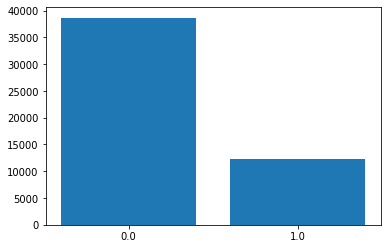

Percentage of Class 0 is : 76.0%
Percentage of Class 1 is : 24.0%


In [266]:
data=train_final[train_final['Response'].isnull()==False]
dt=data['Response'].value_counts().to_dict()
keys=dt.keys()
keys=[str(i) for i in keys]
values=dt.values()
plt.bar(keys,values)
Response_percent=[np.round(i/len(data)*100) for i in values]
plt.show()
print('Percentage of Class {} is : {}%'.format(0,Response_percent[0]))
print('Percentage of Class {} is : {}%'.format(1,Response_percent[1]))

##3.5 Univariate Analysis

###3.5.1 Region_Code

Num of missing values in Region_Code are : 0


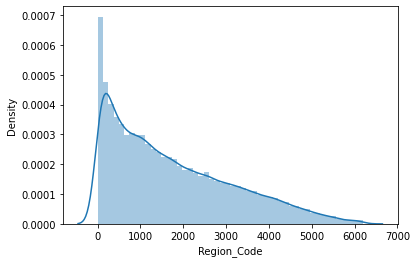

Most Repeated Region_Code is :
 1    140
Name: Region_Code, dtype: int64


In [267]:
print('Num of missing values in Region_Code are :',missing_val_feat_dt['Region_Code'])
sns.distplot(train_df['Region_Code'])
plt.show()
print('Most Repeated Region_Code is :\n',train_df['Region_Code'].value_counts()[:1])

###3.5.2 Upper_Age

Num of missing values in Upper_Age are : 0


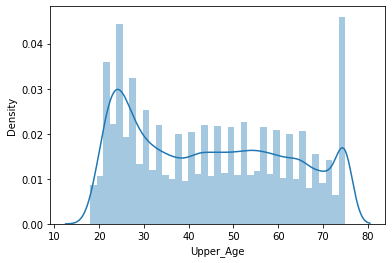

In [268]:
print('Num of missing values in Upper_Age are :',missing_val_feat_dt['Upper_Age'])
sns.distplot(train_df['Upper_Age'])
plt.show()
#print('Top 10 value_counts :\n',train_df['Upper_Age'].value_counts())

###3.5.3 Lower_Age

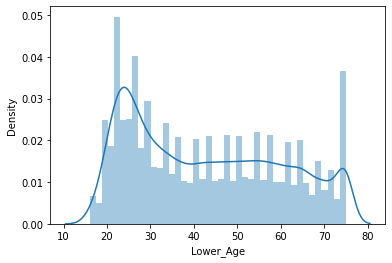

In [269]:
sns.distplot(train_df['Lower_Age'])
plt.show()

###3.5.4 Holding_Policy_Type





Num of missing values in Holding_Policy_Type are : 0


Text(0, 0.5, 'Count of Holding_Policy_Type')

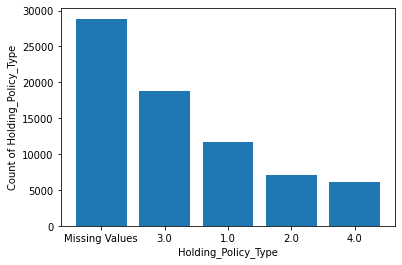

In [270]:
print('Num of missing values in Holding_Policy_Type are :',missing_val_feat_dt['Holding_Policy_Type'])

Region_vc_dt=train_df['Holding_Policy_Type'].value_counts().to_dict()
Region_vc_dt.keys()
Region_vc_dt.values()
keys=[str(i) for i in list(Region_vc_dt.keys())]
#keys.append('Missing Values')
values=list(Region_vc_dt.values())
#values.append(train_df['Holding_Policy_Type'].isna().sum())
keys=['Missing Values']+keys
values=[train_df['Holding_Policy_Type'].isna().sum()]+values
plt.bar(keys,values)
plt.xlabel('Holding_Policy_Type')
plt.ylabel('Count of Holding_Policy_Type')

###3.5.5 Reco_Policy_Cat

Num of missing values in Reco_Policy_Cat are : 0
Total num of Reco_Policy_Cat are : 22


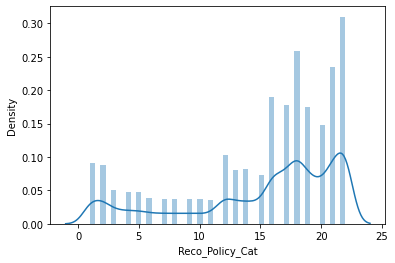

Frequency of Most Repated Reco_Policy_Cat is :
 22    9459
Name: Reco_Policy_Cat, dtype: int64


In [271]:
print('Num of missing values in Reco_Policy_Cat are :',missing_val_feat_dt['Reco_Policy_Cat'])
print('Total num of Reco_Policy_Cat are :',len(train_df['Reco_Policy_Cat'].value_counts()))
sns.distplot(train_df['Reco_Policy_Cat'])
plt.show()
print('Frequency of Most Repated Reco_Policy_Cat is :\n',train_df['Reco_Policy_Cat'].value_counts()[:1])

###3.5.6 Reco_Policy_Premium

Num of missing values in Reco_Policy_Premium are : 0
Total num of Reco_Policy_Premium are : 7685


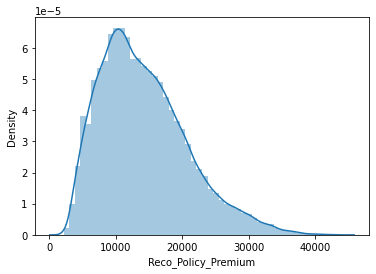

In [272]:
print('Num of missing values in Reco_Policy_Premium are :',missing_val_feat_dt['Reco_Policy_Premium'])
print('Total num of Reco_Policy_Premium are :',len(train_df['Reco_Policy_Premium'].value_counts()))
sns.distplot(train_df['Reco_Policy_Premium'])
plt.show()

###3.5.7 City_Code

Num of missing values in City_Code are : 0
Total num of Unique City_Code are : 36


Text(0, 0.5, 'Count of City_Code')

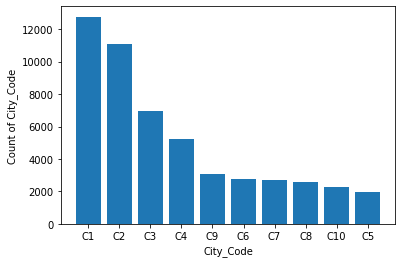

In [273]:
print('Num of missing values in City_Code are :',missing_val_feat_dt['City_Code'])
print('Total num of Unique City_Code are :',len(train_df['City_Code'].value_counts()))

Region_vc_dt=train_df['City_Code'].value_counts().to_dict()
Region_vc_dt.keys()
Region_vc_dt.values()
keys=[str(i) for i in list(Region_vc_dt.keys())]
values=list(Region_vc_dt.values())
plt.bar(keys[:10],values[:10])
plt.xlabel('City_Code')
plt.ylabel('Count of City_Code')

###3.5.8 Accomodation_Type

Num of missing values in Accomodation_Type are : 0
Total num of Unique Accomodation_Type are : 2


Text(0, 0.5, 'Count of Accomodation_Type')

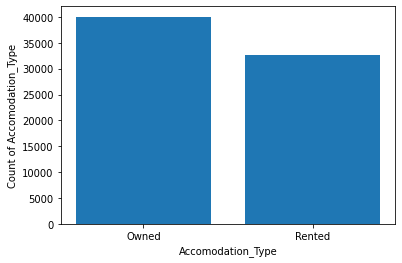

In [274]:
print('Num of missing values in Accomodation_Type are :',missing_val_feat_dt['Accomodation_Type'])
print('Total num of Unique Accomodation_Type are :',len(train_df['Accomodation_Type'].value_counts()))

Region_vc_dt=train_df['Accomodation_Type'].value_counts().to_dict()
Region_vc_dt.keys()
Region_vc_dt.values()
keys=[str(i) for i in list(Region_vc_dt.keys())]
values=list(Region_vc_dt.values())
plt.bar(keys[:10],values[:10])
plt.xlabel('Accomodation_Type')
plt.ylabel('Count of Accomodation_Type')

###3.5.9 Reco_Policy_Cat

Num of missing values in Reco_Insurance_Type are : 0
Total num of Unique Reco_Insurance_Type are : 2


Text(0, 0.5, 'Count of Reco_Insurance_Type')

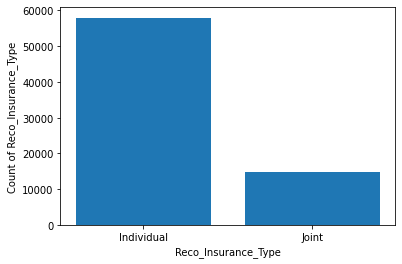

In [275]:
print('Num of missing values in Reco_Insurance_Type are :',missing_val_feat_dt['Reco_Insurance_Type'])
print('Total num of Unique Reco_Insurance_Type are :',len(train_df['Reco_Insurance_Type'].value_counts()))

Region_vc_dt=train_df['Reco_Insurance_Type'].value_counts().to_dict()
Region_vc_dt.keys()
Region_vc_dt.values()
keys=[str(i) for i in list(Region_vc_dt.keys())]
values=list(Region_vc_dt.values())
plt.bar(keys[:10],values[:10])
plt.xlabel('Reco_Insurance_Type')
plt.ylabel('Count of Reco_Insurance_Type')

###3.5.10 Is_Spouse

Num of missing values in Is_Spouse are : 0
Total num of Unique Is_Spouse are : 2


Text(0, 0.5, 'Count of Is_Spouse')

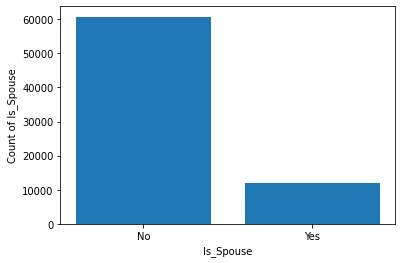

In [276]:
print('Num of missing values in Is_Spouse are :',missing_val_feat_dt['Is_Spouse'])
print('Total num of Unique Is_Spouse are :',len(train_df['Is_Spouse'].value_counts()))

Region_vc_dt=train_df['Is_Spouse'].value_counts().to_dict()
Region_vc_dt.keys()
Region_vc_dt.values()
keys=[str(i) for i in list(Region_vc_dt.keys())]
values=list(Region_vc_dt.values())
plt.bar(keys[:10],values[:10])
plt.xlabel('Is_Spouse')
plt.ylabel('Count of Is_Spouse')

###3.5.11 Health Indicator

Num of missing values in Health Indicator are : 0
Total num of Unique Health Indicator are : 9


Text(0, 0.5, 'Count of Health Indicator')

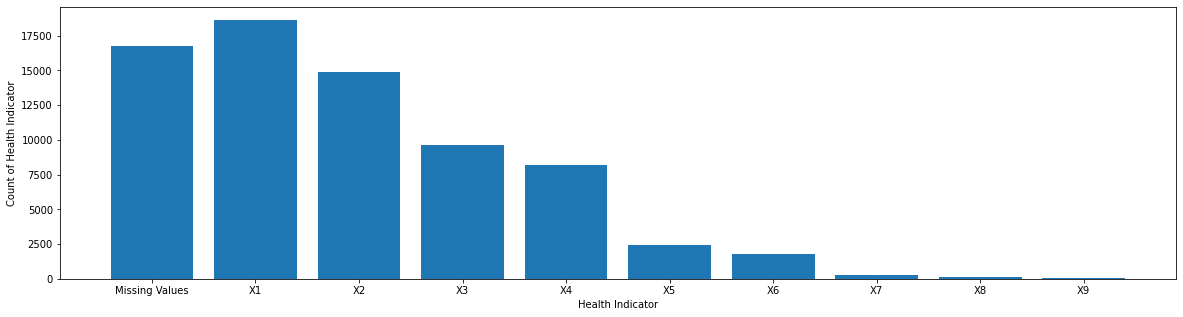

In [277]:
print('Num of missing values in Health Indicator are :',missing_val_feat_dt['Health Indicator'])
print('Total num of Unique Health Indicator are :',len(train_df['Health Indicator'].value_counts()))


Region_vc_dt=train_df['Health Indicator'].value_counts().to_dict()
Region_vc_dt.keys()
Region_vc_dt.values()
keys=[str(i) for i in list(Region_vc_dt.keys())]
values=list(Region_vc_dt.values())
keys=['Missing Values']+keys
values=[train_df['Health Indicator'].isna().sum()]+values
plt.figure(figsize=(20,5))
plt.bar(keys[:10],values[:10])
plt.xlabel('Health Indicator')
plt.ylabel('Count of Health Indicator')

###3.5.12 Holding_Policy_Duration

Num of missing values in Holding_Policy_Duration are : 0
Total num of Unique Holding_Policy_Duration are : 15


Text(0, 0.5, 'Count of Holding_Policy_Duration')

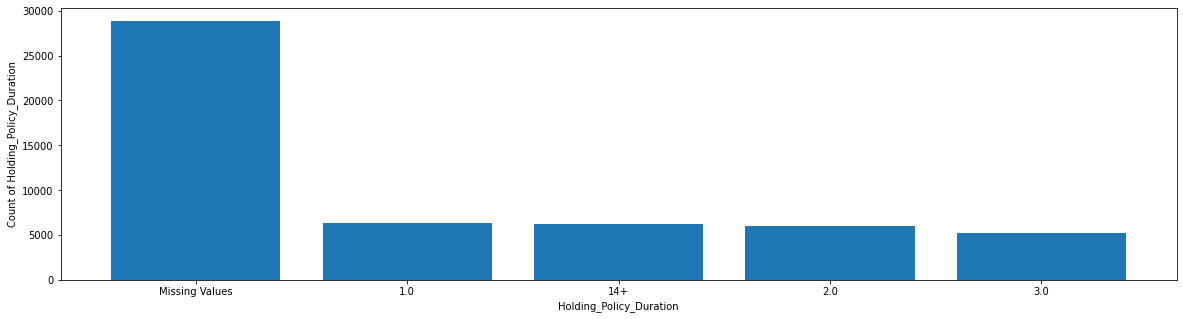

In [278]:
print('Num of missing values in Holding_Policy_Duration are :',missing_val_feat_dt['Holding_Policy_Duration'])
print('Total num of Unique Holding_Policy_Duration are :',len(train_df['Holding_Policy_Duration'].value_counts()))

value_counts_dt=train_df['Holding_Policy_Duration'].value_counts().to_dict()
value_counts_dt.keys()
value_counts_dt.values()
keys=[str(i) for i in list(value_counts_dt.keys())]
values=list(value_counts_dt.values())
keys=['Missing Values']+keys
values=[train_df['Holding_Policy_Duration'].isna().sum()]+values
plt.figure(figsize=(20,5))
plt.bar(keys[:5],values[:5])
plt.xlabel('Holding_Policy_Duration')
plt.ylabel('Count of Holding_Policy_Duration')

##3.6 Filling Missing Values and Adding Missing Value Features

In [279]:
train_df['Holding_Policy_Type_missval_ind']=train_df['Holding_Policy_Type'].isnull().apply(lambda x:1 if x==True else 0)
train_df['Holding_Policy_Duration_missval_ind']=train_df['Holding_Policy_Duration'].isnull().apply(lambda x:1 if x==True else 0)
train_df['Health_Indicator_missval_ind']=train_df['Health Indicator'].isnull().apply(lambda x:1 if x==True else 0)

In [280]:
train_df['Holding_Policy_Type']=train_df['Holding_Policy_Type'].replace(np.NaN,5)
train_df['Holding_Policy_Duration']=train_df['Holding_Policy_Duration'].replace(np.NaN,'missing')
train_df['Health Indicator']=train_df['Health Indicator'].replace(np.NaN,'missing')

##3.7 Encoding Categorical Features

In [281]:
City_Code_dummies=pd.get_dummies(train_df['City_Code'],drop_first=True)

train_df['Accomodation_Type']=train_df['Accomodation_Type'].map({'Rented':0,'Owned':1})
train_df['Reco_Insurance_Type']=train_df['Reco_Insurance_Type'].map({'Individual':0,'Joint':1})
train_df['Is_Spouse']=train_df['Is_Spouse'].map({'Yes':1,'No':0})

keys=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9','missing']
values=[i for i in range(1,11)]
dt=dict(zip(keys,values))
train_df['Health Indicator']=train_df['Health Indicator'].map(dt)

keys=['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '14+','missing']
values=[i for i in range(1,17)]
dt=dict(zip(keys,values))
train_df['Holding_Policy_Duration']=train_df['Holding_Policy_Duration'].map(dt)

#4.Feature Engineering

In [282]:
#Creating New columns by taking mean and difference of Upper and lower age.
train_df['AVG_AGE']=(train_df['Upper_Age']+train_df['Lower_Age'])/2
train_df['ABS_AGE']=(train_df['Upper_Age']-train_df['Lower_Age'])/2

In [283]:
#Creating new columns by taking frequency of the columns
def col_frequency(dataset,col):
  dt=dataset[col].value_counts().to_dict()
  dataset[col+'_freq']=dataset[col].apply(lambda x:dt[x])

#creating columnname_frequency features of the below list of columns
feat_lst=['City_Code','Region_Code','AVG_AGE','Holding_Policy_Type','Reco_Policy_Cat','Health Indicator']
for feature in feat_lst:
  col_frequency(train_df,feature)

In [284]:
#Creating a new features based on groupby operations on 2 columns.
#Here we are using count,mean and sum as operations

def feature_creation_1(data_frame,col1,col2,operation):
  data_frame[col1+'-+-'+col2+'-+-'+operation]=data_frame.groupby([col1])[col2].transform(operation)

feat_lst=['City_Code','Region_Code','AVG_AGE','Holding_Policy_Type','Reco_Policy_Cat']
operation_lst=['sum','count','mean']

for i in operation_lst:
  for j in feat_lst:
    feature_creation_1(train_df,j,'Reco_Policy_Premium',i)

In [285]:
#Creating a new features based on groupby operations on 3 columns
#Here we are using count,mean and sum as operations

def feature_creation_2(data_frame,col1,col2,col3,operation):
  data_frame[col1+'-+-'+col2+'-+-'+col3+'-+-'+operation]=data_frame.groupby([col1,col2])[col3].transform(operation)

feat_lst=['City_Code','Region_Code','AVG_AGE','Holding_Policy_Type','Reco_Policy_Cat']
operation_lst=['sum','count','mean']

for i in operation_lst:
  for j in feat_lst:
    for k in feat_lst:
      if j!=k:
        feature_creation_2(train_df,j,k,'Reco_Policy_Premium',i)

In [286]:
#Creating a new features based on groupby operations on 4 columns
#Here we are using count,mean and sum as operations

feat_lst=['AVG_AGE','Holding_Policy_Type','Holding_Policy_Duration','Reco_Policy_Cat']
operation_lst=['sum','count','mean']

def feature_creation_3(data_frame,col1,col2,col3,col4,operation):
  data_frame[col1+'-+-'+col2+'-+-'+col3+'-+-'+col4+'-+-'+operation]=data_frame.groupby([col1,col2,col3])[col4].transform(operation)
  #print(col1+'-+-'+col2+'-+-'+operation)

for i in operation_lst:
  for j in feat_lst:
    feature_creation_3(train_df,'City_Code','Region_Code',j,'Reco_Policy_Premium',i)

## Merging and dropping columns

In [287]:
train_df=pd.concat([train_df,City_Code_dummies],axis=1)
train_df=train_df.drop(['ID','City_Code'],axis=1)
train_df=train_df.reset_index()
train_df=train_df.drop(['index'],axis=1)
train_df.shape

(72687, 145)

In [288]:
#Using RandomForest Classifier as a Model to Predict Missing values
# Predicting Missing Values in columns Holding_Policy_Type,Health Indicator,Holding_Policy_Duration

from sklearn.ensemble import RandomForestClassifier
def predicting_missval(col,val):
  x_train_miss=train_df[train_df[col]!=val].drop([col,'Response'],axis=1)
  y_train_miss=train_df[train_df[col]!=val][col]

  x_test_miss=train_df[train_df[col]==val].drop([col,'Response'],axis=1)

  rf=RandomForestClassifier()
  rf.fit(x_train_miss,y_train_miss)
  y_test_predict=rf.predict(x_test_miss)
  index_lst=list(x_test_miss.index)
  for i,j in zip(index_lst,y_test_predict):
	  train_df[col].loc[i,val]=j

predicting_missval('Holding_Policy_Type',5)
predicting_missval('Health Indicator',10)
predicting_missval('Holding_Policy_Duration',16)

#5.Feature Selection

###5.1 Dropping Highly Correlated Fetures

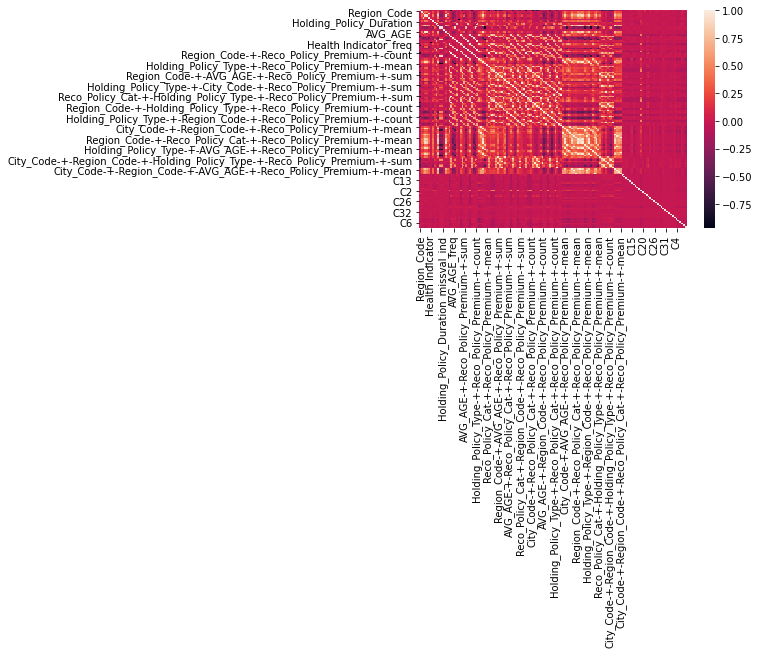

In [290]:
#heatmap of correlation matrix
X=train_df[train_df['Response'].isnull()==False].drop('Response',axis=1)
y=train_df[train_df['Response'].isnull()==False]['Response']
sns.heatmap(X.corr())

In [291]:
#Dropping Highly Correlated Features
cor_matrix = X.corr().abs()
#print(cor_matrix)

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.999)]
print('Num of Highly Correlated Features dropped are :',len(to_drop))
train_final = train_df.drop(to_drop, axis=1)

Num of Highly Correlated Features dropped are : 48


##5.2 Recursive Feature Elimation

<BarContainer object of 10 artists>

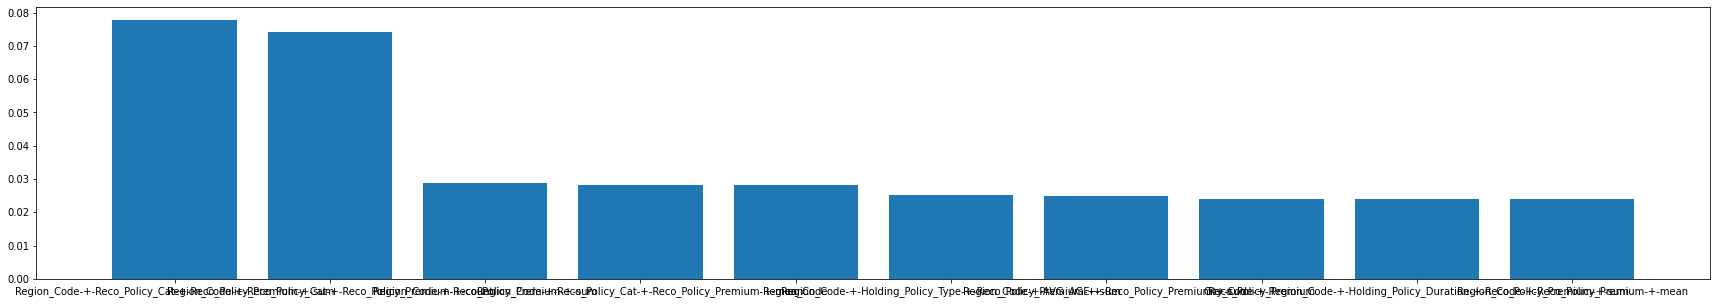

In [292]:
#Printing Top 10 imp features
X=train_final[train_final['Response'].isnull()==False].drop('Response',axis=1)
y=train_final[train_final['Response'].isnull()==False]['Response']
rf=RandomForestClassifier()
rf.fit(X,y)

feature_imp_dt=dict(zip(X.columns,rf.feature_importances_))
sorted_feature_imp_dt=dict(sorted(feature_imp_dt.items(), key=lambda x: x[1], reverse=True))
keys=list(sorted_feature_imp_dt.keys())
values=list(sorted_feature_imp_dt.values())
plt.figure(figsize=(30,5))
plt.bar(keys[:10],values[:10])

In [293]:
#Recurssive Feature Elimination
X=train_final[train_final['Response'].isnull()==False].drop('Response',axis=1)
y=train_final[train_final['Response'].isnull()==False]['Response']

def recurssive_feature_elimination(X,y,n_features_to_remove,feat_imp):
  for i in range(n_features_to_remove):
    rf=RandomForestClassifier()
    rf.fit(X,y)
    feature_imp_dt=dict(zip(X.columns,rf.feature_importances_))
    sorted_feature_imp_dt=dict(sorted(feature_imp_dt.items(), key=lambda x: x[1], reverse=True))
    keys=list(sorted_feature_imp_dt.keys())
    values=list(sorted_feature_imp_dt.values())
    if values[-1]<feat_imp:
      X=X.drop(keys[-1],axis=1)
      print("Feature {} with importance of {} is removed".format(keys[-1],values[-1]))
    else:
      break
  return X 

X=recurssive_feature_elimination(X,y,10,0.01)

Feature C36 with importance of 5.084733918232179e-06 is removed
Feature C31 with importance of 9.14954556173639e-06 is removed
Feature C30 with importance of 2.7155782347595748e-05 is removed
Feature C35 with importance of 3.56408427083771e-05 is removed
Feature C32 with importance of 0.00010916966007796154 is removed
Feature C34 with importance of 0.00012215485686521623 is removed
Feature C27 with importance of 0.00019994851272890193 is removed
Feature C33 with importance of 0.00017835914928679262 is removed
Feature C25 with importance of 0.0001620878190444123 is removed
Feature C28 with importance of 0.00020807935301011963 is removed


In [294]:
#train test split
from sklearn.model_selection import train_test_split
X=train_final[train_final['Response'].isnull()==False].drop('Response',axis=1)
y=train_final[train_final['Response'].isnull()==False]['Response']

x_train,x_cv,y_train,y_cv=train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)
print(x_train.shape,y_train.shape)
print(x_cv.shape,y_cv.shape)

(38161, 96) (38161,)
(12721, 96) (12721,)


#6.Modelling

##6.1 Random Forest

In [ ]:
#for using auc as metric in randomizedcv
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score
def custom_scorer(y_true, y_pred, actual_scorer):
  score = np.nan
  try:
      score = actual_scorer(y_true, y_pred)
  except ValueError: 
      pass
  return score


new_auc = make_scorer(custom_scorer, actual_scorer=roc_auc_score)
bal_acc = make_scorer(custom_scorer,actual_scorer=balanced_accuracy_score)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params={'n_estimators':[100,200,300,500,700,1000],
        'max_depth':[10,30,50,70,100],
        'min_samples_split':[2,5,7,10,20],
        'min_samples_leaf':[1,3,5,10],
        'class_weight':[{0:0.2,1:0.8},{0:0.3,1:0.7}]}

rf=RandomForestClassifier()
#calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
rf_clf=RandomizedSearchCV(rf,params,cv=5,n_iter=20,n_jobs=-1,verbose=10,scoring=new_auc)
rf_clf.fit(X,y)

print('Best Parameter are :',rf_clf.best_params_)

In [ ]:
#AUC
from sklearn.metrics import roc_auc_score

y_train_pred_proba=rf_clf.predict_proba(X)[:,1]
train_auc=roc_auc_score(y_train,y_train_pred_proba)

print(train_auc)

##6.2 XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

params={'n_estimators':[10,50,100,150,200,300],
        'max_depth':[3,5,10,20,30,50,70,100],
        'min_samples_split':[2,5,7,10],
        'min_samples_leaf':[1,2,3,5,10],
        'class_weight':[{0:0.2,1:0.8},{0:0.3,1:0.7}]}

xgb=XGBClassifier()
xgb_clf=RandomizedSearchCV(rf,params,cv=5,n_iter=10,n_jobs=-1,verbose=10,scoring=new_auc)
xgb_clf.fit(X,y)

print('Best Parameter are :',xgb_clf.best_params_)

In [ ]:
#AUC
from sklearn.metrics import roc_auc_score

y_train_pred_proba=xgb_clf.predict_proba(X)[:,1]
train_auc=roc_auc_score(y_train,y_train_pred_proba)

print(train_auc)

##6.3 LGBM

In [ ]:
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_cv,y_cv)],
            'eval_names': ['valid'],
            'verbose': 100}

param_test ={'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight':[1,2,6,12]}
             


lg= LGBMClassifier(metric = 'auc',                
                       # GPU PARAMETERS #
                       device = "gpu",
                       gpu_device_id =0,
                       max_bin = 63,
                       gpu_platform_id=1,
                       # GPU PARAMETERS #
                       n_estimators=50000,    
                       bagging_fraction=0.95, 
                       subsample_freq = 2, 
                       objective ="binary",
                       min_samples_leaf= 2,
                       importance_type = "gain",
                       verbosity = -1,
                       random_state=294,
                       num_leaves = 300,
                       boosting_type = 'gbdt',
                       learning_rate=0.15,
                       max_depth=4, 
                     # scale_pos_weight=2, # Score - 0.85865 | Rank - 18
                       n_jobs=-1 
                      )

lg_clf=RandomizedSearchCV(lg,param_test,cv=3,n_iter=20,n_jobs=-1,verbose=10,scoring=new_auc)
lg_clf.fit(X,y,**fit_params)
print(lg_clf.best_estimator_)

In [ ]:
#AUC
from sklearn.metrics import roc_auc_score
y_train_pred_proba=lg_clf.predict_proba(X)[:,1]

train_auc=roc_auc_score(y_train,y_train_pred_proba)
print(train_auc)

#7.Predictions on Test Data

In [ ]:
test_final=train_final[train_final['Response'].isnull()==True].drop(['Response'],axis=1)

submmission_df=pd.DataFrame(test_df['ID'])
#y_test_pred_proba=rf_clf.predict_proba(test_final)[:,1]
#y_test_pred_proba=xgb_clf.predict_proba(test_final)[:,1]
y_test_pred_proba=lg_clf.predict_proba(test_final)[:, 1]
submmission_df['Response']=y_test_pred_proba
submmission_df.to_csv('Submission.csv',index=False)